# Mount the necessary drives and install detecto lib


In [3]:
import os
from google.colab import drive

drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/AEC Hackathon - LifeSavers/code')

!pip install detecto

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import torch
print(torch.cuda.is_available())

True


# Custom functions (+ tweaked detecto viz)

In [0]:
# loading customized detecto visualize functions.
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch

from detecto.utils import reverse_normalize, normalize_transform, _is_iterable
from torchvision import transforms


def detect_video(model, input_file, output_file, fps=30, score_filter=0.6, labels=[]):
    """Takes in a video and produces an output video with object detection
    run on it (i.e. displays boxes around detected objects in real-time).
    Output videos should have the .avi file extension. Note: some apps,
    such as macOS's QuickTime Player, have difficulty viewing these
    output videos. It's recommended that you download and use
    `VLC <https://www.videolan.org/vlc/index.html>`_ if this occurs.


    :param model: The trained model with which to run object detection.
    :type model: detecto.core.Model
    :param input_file: The path to the input video.
    :type input_file: str
    :param output_file: The name of the output file. Should have a .avi
        file extension.
    :type output_file: str
    :param fps: (Optional) Frames per second of the output video.
        Defaults to 30.
    :type fps: int
    :param score_filter: (Optional) Minimum score required to show a
        prediction. Defaults to 0.6.
    :type score_filter: float

    **Example**::

        >>> from detecto.core import Model
        >>> from detecto.visualize import detect_video

        >>> model = Model.load('model_weights.pth', ['tick', 'gate'])
        >>> detect_video(model, 'input_vid.mp4', 'output_vid.avi', score_filter=0.7)
    """

    # Read in the video
    video = cv2.VideoCapture(input_file)

    # Video frame dimensions
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Scale down frames when passing into model for faster speeds
    scaled_size = 800
    if min(frame_height, frame_width)>scaled_size:
        scale_down_factor = min(frame_height, frame_width) / scaled_size

    # The VideoWriter with which we'll write our video with the boxes and labels
    # Parameters: filename, fourcc, fps, frame_size
    out = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'DIVX'), fps, (frame_width, frame_height))

    # Transform to apply on individual frames of the video
    transform_frame = transforms.Compose([  # TODO Issue #16
        transforms.ToPILImage(),
        transforms.Resize(scaled_size),
        transforms.ToTensor(),
        normalize_transform(),
    ])

    # Loop through every frame of the video
    while True:
        ret, frame = video.read()
        # Stop the loop when we're done with the video
        if not ret:
            break

        # The transformed frame is what we'll feed into our model
        # transformed_frame = transform_frame(frame)
        transformed_frame = frame  # TODO: Issue #16
        predictions = model.predict(transformed_frame)

        # Add the top prediction of each class to the frame
        for label, box, score in zip(*predictions):
            if score < score_filter:
                continue
            if len(labels) > 0 and label not in labels:
                continue
            if label == "person":
                color = (200,200,200)
            elif label == "nohelmet":
                color = (200,10,10)
            elif label == "helmet":
                color = (10,200,10)
            elif label == "nowest":
                color = (200,10,10)
            else:
                color = (150,150,150)

            # Since the predictions are for scaled down frames,
            # we need to increase the box dimensions
            # box *= scale_down_factor  # TODO Issue #16
            box = [b*scale_down_factor for b in box]

            # Create the box around each object detected
            # Parameters: frame, (start_x, start_y), (end_x, end_y), (r, g, b), thickness
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), color, 2)

            # Write the label and score for the boxes
            # Parameters: frame, text, (start_x, start_y), font, font scale, (r, g, b), thickness
            #cv2.putText(frame, '{}: {}'.format(label, round(score.item(), 2)), (box[0], box[1] - 10),
            #            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

        # Write this frame to our video file
        out.write(frame)

        # If the 'q' key is pressed, break from the loop
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

    # When finished, release the video capture and writer objects
    video.release()
    out.release()

    # Close all the frames
    cv2.destroyAllWindows()


def plot_prediction_grid(model, images, dim=None, figsize=None, score_filter=0.6):
    """Plots a grid of images with boxes drawn around predicted objects.

    :param model: The trained model with which to run object detection.
    :type model: detecto.core.Model
    :param images: An iterable of images to plot. If the images are
        normalized torch.Tensor images, they will automatically be
        reverse-normalized and converted to PIL images for plotting.
    :type images: iterable
    :param dim: (Optional) The dimensions of the grid in the format
        ``(rows, cols)``. If no value is given, the grid is of the shape
        ``(len(images), 1)``. ``rows * cols`` must match the number of
        given images, or a ValueError is raised. Defaults to None.
    :type dim: tuple or None
    :param figsize: (Optional) The size of the entire grid in the format
        ``(width, height)``. Defaults to None.
    :type figsize: tuple or None
    :param score_filter: (Optional) Minimum score required to show a
        prediction. Defaults to 0.6.
    :type score_filter: float

    **Example**::

        >>> from detecto.core import Model
        >>> from detecto.utils import read_image
        >>> from detecto.visualize import plot_prediction_grid

        >>> model = Model.load('model_weights.pth', ['tick', 'gate'])
        >>> images = []
        >>> for i in range(4):
        >>>     image = read_image('image{}.jpg'.format(i))
        >>>     images.append(image)
        >>> plot_prediction_grid(model, images, dim=(2, 2), figsize=(8, 8))
    """

    # If not specified, show all in one column
    if dim is None:
        dim = (len(images), 1)

    if dim[0] * dim[1] != len(images):
        raise ValueError('Grid dimensions do not match size of list of images')

    fig, axes = plt.subplots(dim[0], dim[1], figsize=figsize)

    # Loop through each image and position in the grid
    index = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            image = images[index]
            preds = model.predict(image)

            # If already a tensor, reverse normalize it and turn it back
            if isinstance(image, torch.Tensor):
                image = transforms.ToPILImage()(reverse_normalize(image))
            index += 1

            # Get the correct axis
            if dim[0] <= 1 and dim[1] <= 1:
                ax = axes
            elif dim[0] <= 1:
                ax = axes[j]
            elif dim[1] <= 1:
                ax = axes[i]
            else:
                ax = axes[i, j]

            ax.imshow(image)

            # Plot boxes and labels
            for label, box, score in zip(*preds):
                if score >= score_filter:
                    width, height = box[2] - box[0], box[3] - box[1]
                    initial_pos = (box[0], box[1])
                    rect = patches.Rectangle(initial_pos, width, height, linewidth=1,
                                             edgecolor='r', facecolor='none')
                    ax.add_patch(rect)

                    ax.text(box[0] + 5, box[1] - 10, '{}: {}'
                            .format(label, round(score.item(), 2)), color='red')
                ax.set_title('Image {}'.format(index))

    plt.show()


def show_labeled_image(image, boxes, labels=None):
    """Show the image along with the specified boxes around detected objects.
    Also displays each box's label if a list of labels is provided.

    :param image: The image to plot. If the image is a normalized
        torch.Tensor object, it will automatically be reverse-normalized
        and converted to a PIL image for plotting.
    :type image: numpy.ndarray or torch.Tensor
    :param boxes: A torch tensor of size (N, 4) where N is the number
        of boxes to plot, or simply size 4 if N is 1.
    :type boxes: torch.Tensor
    :param labels: (Optional) A list of size N giving the labels of
            each box (labels[i] corresponds to boxes[i]). Defaults to None.
    :type labels: torch.Tensor or None

    **Example**::

        >>> from detecto.core import Model
        >>> from detecto.utils import read_image
        >>> from detecto.visualize import show_labeled_image

        >>> model = Model.load('model_weights.pth', ['tick', 'gate'])
        >>> image = read_image('image.jpg')
        >>> labels, boxes, scores = model.predict(image)
        >>> show_labeled_image(image, boxes, labels)
    """

    fig, ax = plt.subplots(1)
    # If the image is already a tensor, convert it back to a PILImage
    # and reverse normalize it
    if isinstance(image, torch.Tensor):
        image = reverse_normalize(image)
        image = transforms.ToPILImage()(image)
    ax.imshow(image)

    # Show a single box or multiple if provided
    if boxes.ndim == 1:
        boxes = boxes.view(1, 4)

    if labels is not None and not _is_iterable(labels):
        labels = [labels]

    # Plot each box
    for i in range(boxes.shape[0]):
        box = boxes[i]
        width, height = (box[2] - box[0]).item(), (box[3] - box[1]).item()
        initial_pos = (box[0].item(), box[1].item())
        rect = patches.Rectangle(initial_pos,  width, height, linewidth=1,
                                 edgecolor='r', facecolor='none')
        if labels:
            ax.text(box[0] + 5, box[1] - 5, '{}'.format(labels[i]), color='red')

        ax.add_patch(rect)

    plt.show()



def filter_inputs(labels, boxes, scores):
    """
    filter eventual categories off. Returns list of labels,boxes,scores in
    the accepted_labels
    """

    accepted_labels = ["person","nohelmet","nowest"]
    labels2 = []
    boxes2 = []
    scores2 = []
    for i, label in enumerate(labels):
        if label in accepted_labels:
            labels2.append(labels[i])
            if len(boxes2) == 0:
                boxes2 = boxes[i]
            else:
                boxes2 = torch.cat([boxes2,boxes[i]],-1)
            scores2.append(scores[i])
    boxes2 = boxes2.view(-1, 4)

    return labels2, boxes2, scores2

# Demo Functions for Core Model

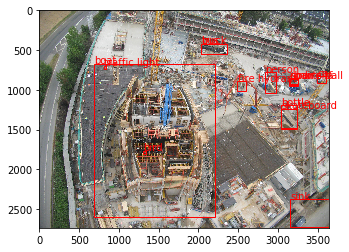

In [7]:
from detecto import core, utils, visualize

image = utils.read_image('../Label Fotos/COMBINED_DATA/IMG_012674.jpg')
model = core.Model()

labels, boxes, scores = model.predict_top(image)

show_labeled_image(image, boxes, labels)

# Training the model


In [0]:
from detecto import core, utils, visualize

dataset = core.Dataset('/content/drive/My Drive/AEC Hackathon - LifeSavers/Label Fotos/COMBINED_DATA')
print(len(dataset))
#model = core.Model(['person','helmet','nohelmet','nowest'])
model = core.Model(['person'])
model.fit(dataset)
print("Training done")

1599


#OR open existing model

In [0]:
model = core.Model.load('safetyheroes_model_v3.pth', ['person'])
print("loaded")

loaded


# Test the Model on unlabelled data

tensor([[1359.4390, 1422.3409, 1395.3772, 1485.3767],
        [1150.2283, 1390.0052, 1189.7900, 1449.3566],
        [1793.0596, 2501.9114, 1832.5846, 2556.7483],
        [1130.4922, 1635.7881, 1164.2905, 1709.5801],
        [1245.0466, 1126.6442, 1281.0432, 1199.7257],
        [1764.8929, 2555.5725, 1802.0912, 2602.1716],
        [1500.2809,  659.8734, 1533.4017,  708.9918],
        [1821.6371, 2577.0627, 1852.3026, 2623.1262],
        [1784.3016, 2415.9492, 1818.2352, 2462.6841],
        [1174.1067, 1530.6760, 1217.1583, 1597.1384],
        [1854.5867,  311.0101, 1891.8334,  375.5647],
        [2726.5544, 1188.7222, 2763.0618, 1243.4835],
        [1361.5430, 1310.9893, 1400.9373, 1357.5280],
        [2603.1494,  582.1873, 2631.2112,  628.8705],
        [2596.7683, 1074.4244, 2634.0664, 1126.0283],
        [2266.9006,  471.6356, 2295.4458,  525.8494],
        [ 707.7574, 1817.2377,  745.9027, 1888.1989],
        [2624.5710, 1310.1740, 2667.3105, 1363.6400],
        [3492.2273, 1675.097

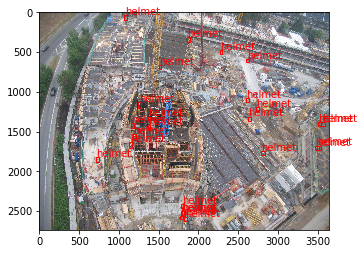

Time:  1.2150243169999158


In [0]:
# Specify the path to your image
import timeit


images = ['IMG_006794.jpg','IMG_007904.jpg','IMG_008478.jpg']
path = '../test_set/'

for img in images:
    start = timeit.default_timer()
    image = utils.read_image(path + img)

    predictions = model.predict(image)

    # predictions format: (labels, boxes, scores)
    labels, boxes, scores = predictions

    # ['alien', 'bat', 'bat']
    #print(labels) 

    #           xmin       ymin       xmax       ymax
    # tensor([[ 569.2125,  203.6702, 1003.4383,  658.1044],
    #         [ 276.2478,  144.0074,  579.6044,  508.7444],
    #print(boxes)

    # tensor([0.9952, 0.9837, 0.5153])
    #print(scores)

    # Eventually sort away helmets
    #labels, boxes, scores = filter_inputs(labels,boxes,scores)

    visualize.show_labeled_image(image, boxes, labels)
    stop = timeit.default_timer()

    print('Time: ', stop - start)

# Save model

In [0]:
#model.save('safetyheroes_model_v3.pth')